# Health effects of temperature change


Excel spreadsheet: Columns -> countries, Rows -> years

Generate plots anyways

Generate maps


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC


In [3]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [9]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/summer temperature change/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'summer_temperature'/ 'results_2020'

# POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
POPULATION_FILE = POP_DATA_SRC / 'population_ismip_and_gpw4_era_compat.nc'
DEMOGRAPHICS_FILE = POP_DATA_SRC / 'demographics_pct_1950_2050.nc'
DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_1950_2020.nc'

COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpwv4/gpw_v4_national_identifier_lookup.txt'
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'

## Load country data

In [7]:
# COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [8]:
COUNTRIES_LOOKUP.head()

GRIDCODE ISOCODE  UNSDCODE           NAME0  CIESINCODE  \
0         4     AFG         4     Afghanistan           4   
1         8     ALB         8         Albania           8   
2        12     DZA        12         Algeria          12   
3        16     ASM        16  American Samoa          16   
4        20     AND        20         Andorra          20   

                         DATATYPE  DATACODE  DATAYEAR  DATALEVEL  GRSTART  \
0  Population estimate/projection         6      2011          2     1998   
1                    Final census         1      2011          3     2001   
2                    Final census         1      2008          2     1998   
3                    Final census         1      2010          3     2000   
4             Population register         5      2010          1     2000   

   GREND  GRLEVEL  LASTCENSUS    MEANUNITKM  
0   2011        1        1979   4507.466751  
1   2011        3        2011    115.949835  
2   2008        2        2008  50884.794880  
3   2010        3        2010      7.612468  
4   2010        1        2011     79.902822

### Load the temperature anomaly data

In [10]:
# Load the anomaly raster
summer_anom = xr.open_dataarray(INTERMEDIATE_RESULTS_FOLDER / 'summer_temperature_anomaly.nc')

In [11]:
global_timeseries = pd.read_excel(RESULTS_FOLDER / 'temperature_change.xlsx', 
                                sheet_name='temperature_change').set_index('year')

In [12]:
global_timeseries.head()

Global mean change K  Exposure weighted change K
year                                                  
2000             -0.043551                    0.011030
2001              0.064386                    0.059222
2002              0.090686                    0.292408
2003              0.138186                    0.261136
2004              0.065551                   -0.045770

## Load the population data

In [13]:
population = xr.open_dataarray(POPULATION_FILE)

## Exposure weighted change by country

In [21]:
weighted_results = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_population = (country_mask * population).sum(dim=['latitude', 'longitude'])
    country_exposures_ts = (summer_anom * population * country_mask / country_population).sum(dim=['latitude', 'longitude'])

    weighted_results.append(country_exposures_ts.to_dataframe(row.ISOCODE))

weighted_results = pd.concat(weighted_results, axis=1)

100%|██████████| 248/248 [01:07<00:00,  3.68it/s]


Delete results for countries where every value is zero (glitched)

In [30]:
weighted_results.to_csv(INTERMEDIATE_RESULTS_FOLDER / 'weighted_change_by_country.csv')

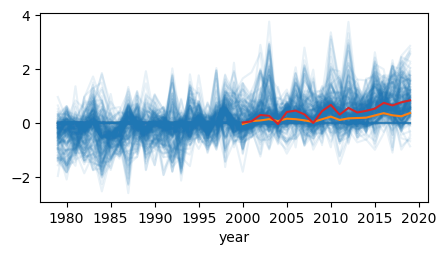

In [16]:
weighted_results.plot(style='C0', legend=False, alpha=0.1)
global_timeseries['Global mean change K'].plot(style='C1', legend=False)
global_timeseries['Exposure weighted change K'].plot(style='C3', legend=False)

In [19]:
weighted_results = weighted_results.stack().reset_index()

In [20]:
weighted_results.columns = ['year', 'iso3_code', '']

year level_1         0
0      1979     AFG -0.059255
1      1979     ALB -0.924086
2      1979     DZA -1.139433
3      1979     ASM -0.186595
4      1979     AND  0.000000
...     ...     ...       ...
10163  2019     IOT  0.000000
10164  2019     SGS  0.000000
10165  2019     SPR  0.000000
10166  2019     UMI  0.000000
10167  2019     KOS  1.563316

[10168 rows x 3 columns]

In [67]:
# # Append the results to the excel file as a new sheet
# with pd.ExcelWriter(RESULTS_FOLDER / f'temperature_change.xlsx', mode='a') as writer:
#     weighted_results.to_excel(writer, sheet_name='countries_exposure_weighted')

## Area weighted.

In [63]:
mean_results = []
    
for _, row in tqdm(COUNTRIES_LOOKUP.iterrows(), total=len(COUNTRIES_LOOKUP)):
    grid_code = row.GRIDCODE
    country_mask = COUNTRIES_RASTER.country_codes == grid_code
    country_area = (country_mask * globe_areas).sum(dim=['latitude', 'longitude'])
    country_mean_ts = (summer_anom * globe_areas * country_mask / country_area).sum(dim=['latitude', 'longitude'])

    mean_results.append(country_mean_ts.to_dataframe(row.ISOCODE))

mean_results = pd.concat(mean_results, axis=1)